In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
df = pd.read_csv("data/alzheimers_prediction_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

In [4]:
df.head()

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


In [5]:
df.describe()

,Age,Education Level,BMI,Cognitive Test Score
count,74283.000000,74283.000000,74283.000000,74283.000000
mean,71.964703,9.487514,26.780639,64.654241
std,12.980748,5.757020,4.764679,20.153247
min,50.000000,0.000000,18.500000,30.000000
25%,61.000000,4.000000,22.700000,47.000000
50%,72.000000,9.000000,26.800000,65.000000
75%,83.000000,14.000000,30.900000,82.000000
max,94.000000,19.000000,35.000000,99.000000


In [6]:
df.dtypes

Country                                  object
Age                                       int64
Gender                                   object
Education Level                           int64
BMI                                     float64
Physical Activity Level                  object
Smoking Status                           object
Alcohol Consumption                      object
Diabetes                                 object
Hypertension                             object
Cholesterol Level                        object
Family History of Alzheimer’s            object
Cognitive Test Score                      int64
Depression Level                         object
Sleep Quality                            object
Dietary Habits                           object
Air Pollution Exposure                   object
Employment Status                        object
Marital Status                           object
Genetic Risk Factor (APOE-ε4 allele)     object
Social Engagement Level                 

In [7]:
for col in df.select_dtypes(include='object'):
    print(f"\nColumn: {col}")
    print(df[col].value_counts())


Column: Country
Country
Brazil          3839
Germany         3807
Australia       3787
Russia          3778
South Africa    3760
Japan           3751
India           3741
South Korea     3732
Argentina       3731
Italy           3724
Canada          3711
France          3710
Norway          3706
Spain           3698
Sweden          3689
Saudi Arabia    3662
UK              3651
USA             3616
Mexico          3598
China           3592
Name: count, dtype: int64

Column: Gender
Gender
Female    37249
Male      37034
Name: count, dtype: int64

Column: Physical Activity Level
Physical Activity Level
High      24853
Low       24754
Medium    24676
Name: count, dtype: int64

Column: Smoking Status
Smoking Status
Current    24915
Never      24740
Former     24628
Name: count, dtype: int64

Column: Alcohol Consumption
Alcohol Consumption
Never           24865
Regularly       24738
Occasionally    24680
Name: count, dtype: int64

Column: Diabetes
Diabetes
No     59527
Yes    14756
Name: c

In [15]:
# 2. Identify column types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove("Alzheimer’s Diagnosis")  # Remove target from features

In [13]:
categorical_cols

['Country',
 'Gender',
 'Physical Activity Level',
 'Smoking Status',
 'Alcohol Consumption',
 'Diabetes',
 'Hypertension',
 'Cholesterol Level',
 'Family History of Alzheimer’s',
 'Depression Level',
 'Sleep Quality',
 'Dietary Habits',
 'Air Pollution Exposure',
 'Employment Status',
 'Marital Status',
 'Genetic Risk Factor (APOE-ε4 allele)',
 'Social Engagement Level',
 'Income Level',
 'Stress Levels',
 'Urban vs Rural Living',
 'Alzheimer’s Diagnosis']

In [18]:
# Define column groups
numerical_cols = ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']

binary_cols = ['Gender', 'Diabetes', 'Hypertension', 'Cholesterol Level', 
               'Family History of Alzheimer’s', 'Genetic Risk Factor (APOE-ε4 allele)', 
               'Urban vs Rural Living']

nominal_cols = ['Country', 'Smoking Status', 'Alcohol Consumption', 
                'Employment Status', 'Marital Status']

In [19]:
# Define ordinal mappings with correct order for each ordinal variable
physical_activity_order = ['Low', 'Medium', 'High']
depression_order = ['Low', 'Medium', 'High']
sleep_order = ['Poor', 'Average', 'Good']
diet_order = ['Unhealthy', 'Average', 'Healthy']
pollution_order = ['Low', 'Medium', 'High']
social_order = ['Low', 'Medium', 'High']
income_order = ['Low', 'Medium', 'High']
stress_order = ['Low', 'Medium', 'High']

In [20]:
# Create ordinal encoder for each ordinal feature with its specific ordering
ordinal_transformers = [
    ('physical', OrdinalEncoder(categories=[physical_activity_order]), ['Physical Activity Level']),
    ('depression', OrdinalEncoder(categories=[depression_order]), ['Depression Level']),
    ('sleep', OrdinalEncoder(categories=[sleep_order]), ['Sleep Quality']),
    ('diet', OrdinalEncoder(categories=[diet_order]), ['Dietary Habits']),
    ('pollution', OrdinalEncoder(categories=[pollution_order]), ['Air Pollution Exposure']),
    ('social', OrdinalEncoder(categories=[social_order]), ['Social Engagement Level']),
    ('income', OrdinalEncoder(categories=[income_order]), ['Income Level']),
    ('stress', OrdinalEncoder(categories=[stress_order]), ['Stress Levels'])
]


In [23]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('bin', OrdinalEncoder(), binary_cols),
        ('nom', OneHotEncoder(drop='first', handle_unknown='ignore'), nominal_cols),
        *ordinal_transformers
    ],
    remainder='drop'  # Drop any columns not specified
)

In [24]:
# Use preprocessing pipeline
X = df.drop('Alzheimer’s Diagnosis', axis=1)
X_transformed = preprocessor.fit_transform(X)

In [26]:
X_transformed

array([[ 1.38939751, -1.47429936,  1.30531403, ...,  0.        ,
         1.        ,  2.        ],
       [ 0.00271923, -0.43208651,  0.65468876, ...,  2.        ,
         0.        ,  2.        ],
       [ 1.08124678,  1.65233921, -0.81446507, ...,  0.        ,
         1.        ,  2.        ],
       ...,
       [-1.15284599,  0.61012635,  0.29789426, ...,  2.        ,
         0.        ,  0.        ],
       [ 0.07975692, -0.43208651,  0.46579755, ...,  0.        ,
         0.        ,  2.        ],
       [-1.15284599, -1.47429936,  1.03247117, ...,  0.        ,
         1.        ,  1.        ]], shape=(74283, 46))

In [27]:
feature_names = preprocessor.get_feature_names_out()
# Create DataFrame with transformed data and proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
print(feature_names)

['num__Age' 'num__Education Level' 'num__BMI' 'num__Cognitive Test Score'
 'bin__Gender' 'bin__Diabetes' 'bin__Hypertension'
 'bin__Cholesterol Level' 'bin__Family History of Alzheimer’s'
 'bin__Genetic Risk Factor (APOE-ε4 allele)' 'bin__Urban vs Rural Living'
 'nom__Country_Australia' 'nom__Country_Brazil' 'nom__Country_Canada'
 'nom__Country_China' 'nom__Country_France' 'nom__Country_Germany'
 'nom__Country_India' 'nom__Country_Italy' 'nom__Country_Japan'
 'nom__Country_Mexico' 'nom__Country_Norway' 'nom__Country_Russia'
 'nom__Country_Saudi Arabia' 'nom__Country_South Africa'
 'nom__Country_South Korea' 'nom__Country_Spain' 'nom__Country_Sweden'
 'nom__Country_UK' 'nom__Country_USA' 'nom__Smoking Status_Former'
 'nom__Smoking Status_Never' 'nom__Alcohol Consumption_Occasionally'
 'nom__Alcohol Consumption_Regularly' 'nom__Employment Status_Retired'
 'nom__Employment Status_Unemployed' 'nom__Marital Status_Single'
 'nom__Marital Status_Widowed' 'physical__Physical Activity Level'
 '

In [28]:
X_transformed_df.head()

,num__Age,num__Education Level,num__BMI,num__Cognitive Test Score,bin__Gender,bin__Diabetes,bin__Hypertension,bin__Cholesterol Level,bin__Family History of Alzheimer’s,bin__Genetic Risk Factor (APOE-ε4 allele),...,nom__Marital Status_Single,nom__Marital Status_Widowed,physical__Physical Activity Level,depression__Depression Level,sleep__Sleep Quality,diet__Dietary Habits,pollution__Air Pollution Exposure,social__Social Engagement Level,income__Income Level,stress__Stress Levels
0,1.389398,-1.474299,1.305314,1.257660,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,2.0
1,0.002719,-0.432087,0.654689,0.017157,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,2.0,2.0,1.0,2.0,0.0,2.0
2,1.081247,1.652339,-0.814465,-1.074486,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0
3,-1.460997,1.304935,0.927532,0.811079,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0
4,-1.075808,-1.126895,0.675677,-0.776765,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0


In [29]:
# For the target variable
y = (df['Alzheimer’s Diagnosis'] == 'Yes').astype(int)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.25, random_state=42, stratify=y
)

In [32]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, lr_preds))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.74      0.79      0.77     10893
           1       0.67      0.61      0.64      7678

    accuracy                           0.72     18571
   macro avg       0.71      0.70      0.70     18571
weighted avg       0.71      0.72      0.71     18571

Random Forest Results:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77     10893
           1       0.67      0.64      0.66      7678

    accuracy                           0.72     18571
   macro avg       0.71      0.71      0.71     18571
weighted avg       0.72      0.72      0.72     18571



In [33]:
# Example for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

/mnt/c/Users/fieng/OneDrive/PersonalProjects/AlzheimerPrediction/myenv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


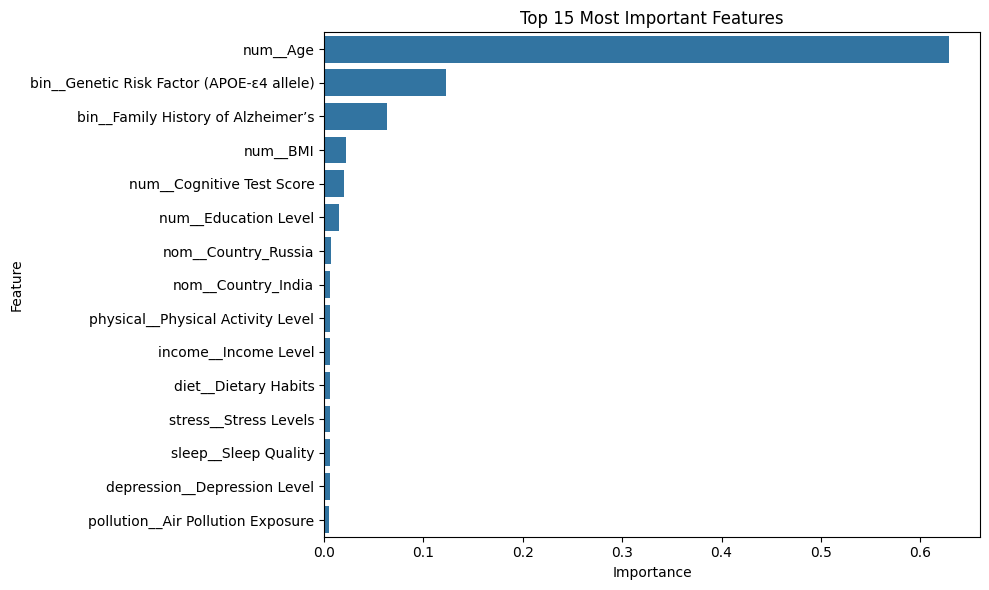

In [40]:
if hasattr(best_rf, 'feature_importances_'):
    importances = best_rf.feature_importances_
    feature_names = preprocessor.get_feature_names_out()
    
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.76      0.77      0.77     10893
           1       0.67      0.66      0.67      7678

    accuracy                           0.73     18571
   macro avg       0.72      0.72      0.72     18571
weighted avg       0.73      0.73      0.73     18571



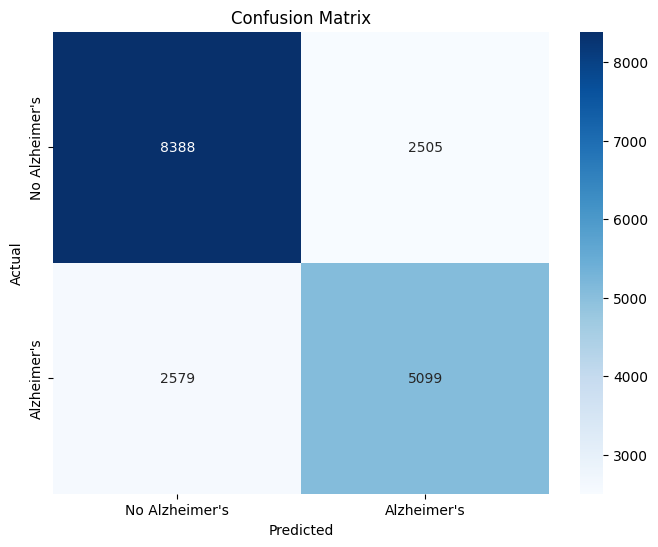

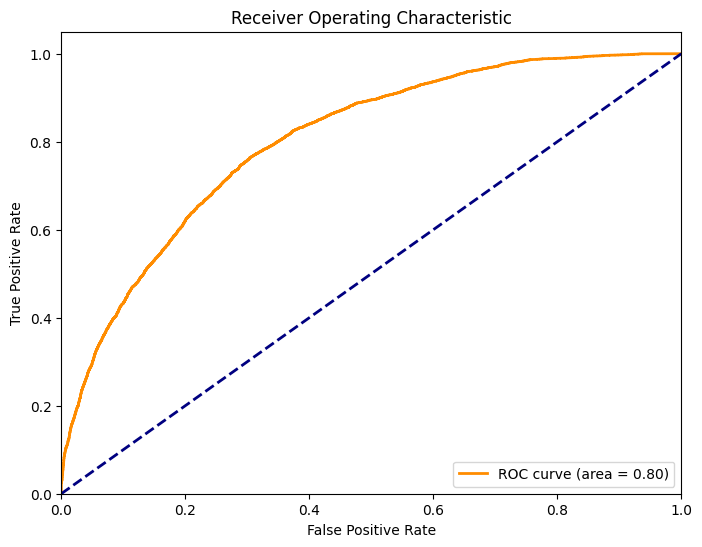

In [41]:
best_preds = best_rf.predict(X_test)
best_probs = best_rf.predict_proba(X_test)[:, 1]

# Classification metrics
print(classification_report(y_test, best_preds))

# Confusion matrix
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Alzheimer\'s', 'Alzheimer\'s'],
            yticklabels=['No Alzheimer\'s', 'Alzheimer\'s'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, best_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()